In [1]:
# ! pip install numpy pillow svgwrite matplotlib==3.7 pandas tikzplotlib
! python --version

Python 3.13.2


In [2]:
BASE_DIR = "../cpp-bfvars/icisn-csv"
BASE_DIR = "./icisn-csv"

# CSV output handler

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [4]:
run_ids = [
    filename.split("icisn-config-")[1][:-4] 
    for filename 
    in os.listdir(BASE_DIR) 
    if "icisn-config" in filename and "Zone" not in filename
]

perf_dfs = []

for run_id in run_ids[:]:
    conf_filename = f"{BASE_DIR}/icisn-config-{run_id}.csv"
    perf_filename = f"{BASE_DIR}/icisn-result-{run_id}.csv"
    
    conf_df = pd.read_csv(conf_filename, delimiter="/", index_col=False)
    perf_df = pd.read_csv(perf_filename, delimiter="/", index_col=False)
    
    for col in conf_df.columns:
        perf_df[col] = conf_df[col][0]
        
    perf_df["RunId"] = run_id
    perf_df["Filename"] = perf_filename

    if perf_df["TestCase"].isna().any():
        print("WTF is wrong with", perf_filename)
        continue

    perf_df = perf_df[perf_df["BinarySearchTime"] > 0]
    perf_df = perf_df[perf_df["OperationTime"] > 0]
    
    perf_df.to_csv("test.csv", index=False)
    perf_dfs.append(perf_df)

perf_df = (
    pd
    .concat(perf_dfs)
    .sort_values(by=["FilterID", "TestCase", "HashAlgo", "HashScheme", "RunId"])
)

perf_df.to_csv("raw.csv", index=False)

In [5]:
perf_df_1 = perf_df
perf_df_1 = perf_df_1.reset_index().drop("index", axis=1)

In [6]:
# time_acc_collision_perf_base_df = perf_df_1
# removable_perf_base_df = perf_df_1
time_acc_collision_perf_base_df = perf_df_1[perf_df_1["TestCase"] == "InsertSet1,2,3"]
removable_perf_base_df = perf_df_1[perf_df_1["TestCase"] == "RemoveSet1"]
time_acc_collision_perf_base_df = time_acc_collision_perf_base_df[
    ~time_acc_collision_perf_base_df["HashAlgo"].str.contains("_split")
    & ~time_acc_collision_perf_base_df["HashAlgo"].str.contains("_xor")
    & ~time_acc_collision_perf_base_df["HashAlgo"].str.contains("_cast")
]
removable_perf_base_df = removable_perf_base_df[
    ~removable_perf_base_df["HashAlgo"].str.contains("_split")
    & ~removable_perf_base_df["HashAlgo"].str.contains("_xor")
    & ~removable_perf_base_df["HashAlgo"].str.contains("_cast")
]
time_acc_collision_perf_base_df[["HashAlgo", "HashScheme", "Accuracy", "TestTime", "AddOrRemoveTime", "NofCollision", "Filename"]].sort_values(by=["HashAlgo", "HashScheme"]).to_csv("time_acc_collision_perf_base_df.csv")
removable_perf_base_df[["HashAlgo", "HashScheme", "NofRemovable", "Filename"]].sort_values(by=["HashAlgo", "HashScheme"]).to_csv("removable_perf_base_df.csv")

In [7]:
# Norm configs
normalize = {
    # "bf": True,
    # "bs": True,
}
normalize_bf_time = normalize.get("bf", False)
normalize_bs_time = normalize.get("bs", False)

# Calculate BF norm DF
bf_norm_testcases = [
    "InsertSet1,2,3", 
    # "InsertSet1",
]
norm_df = pd.read_csv("to-norm.csv", delimiter="/", index_col=False)
norm_df = (
    norm_df[
        norm_df["TestCase"].str.contains("|".join(bf_norm_testcases))
    ]
)

normed = (
    norm_df
    .groupby(["FilterID"])
    .mean(numeric_only=True)
    .reset_index()
    .to_dict(orient="list")
)

normed_add_or_remove_time = normed["AddOrRemoveTime"][0]
normed_test_time = normed["TestTime"][0]

# Calculate BS norm DF
bs_norm_testcases = [
    "InsertSet1,2,3", 
    # "InsertSet1",
]
norm_df = pd.read_csv("to-norm.csv", delimiter="/", index_col=False)
norm_df = (
    norm_df[
        norm_df["TestCase"].str.contains("|".join(bs_norm_testcases))
    ]
)
normed = (
    norm_df
    .groupby(["FilterID"])
    .mean(numeric_only=True)
    .reset_index()
    .to_dict(orient="list")
)

normed_binsearch_time = normed["BinarySearchTime"][0]
normed_operation_time = normed["OperationTime"][0]

In [8]:
fake_df = (
    time_acc_collision_perf_base_df[time_acc_collision_perf_base_df["HashScheme"] == "kir-mitz"]
    .groupby(["FilterID", "HashAlgo", "HashScheme"])
    .mean(numeric_only=True)
    .reset_index()
)
fake_df = fake_df[["FilterID", "HashAlgo", "HashScheme", "AddOrRemoveTime", "TestTime", "OperationTime", "BinarySearchTime"]]
fake_df["AddOrRemoveTime"] = (fake_df["AddOrRemoveTime"] / fake_df["AddOrRemoveTime"].max()) * normed_add_or_remove_time
fake_df["TestTime"] = (fake_df["TestTime"] / fake_df["TestTime"].max()) * normed_test_time

fake_df["OperationTime"] = (fake_df["OperationTime"] / fake_df["OperationTime"].max()) * normed_operation_time
fake_df["BinarySearchTime"] = (fake_df["BinarySearchTime"] / fake_df["BinarySearchTime"].max()) * normed_binsearch_time

fake_df

,FilterID,HashAlgo,HashScheme,AddOrRemoveTime,TestTime,OperationTime,BinarySearchTime
0,DelBF,fnv1a,kir-mitz,0.952924,5.519920,0.289375,0.732503
1,DelBF,murmur3_128,kir-mitz,0.315374,4.363224,0.317593,0.567263
2,DelBF,murmur3_32,kir-mitz,0.940117,1.528307,0.324253,0.690818
3,DelBF,siphash,kir-mitz,1.284310,5.462747,0.374554,0.669802


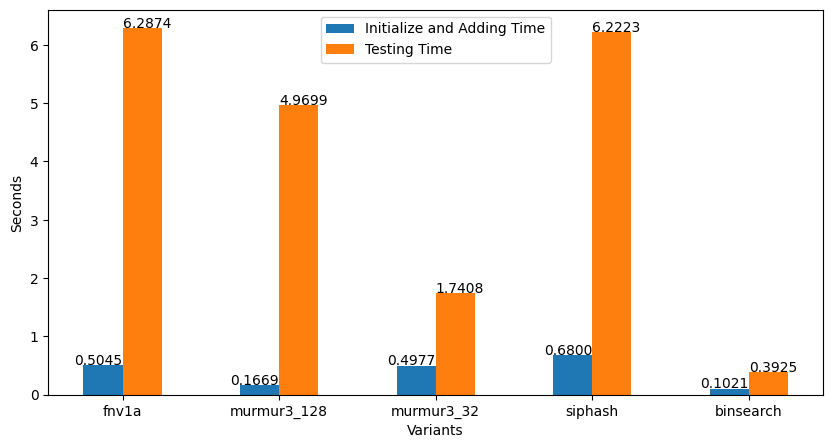

In [9]:
# Sample data
for hash_scheme in perf_df_1["HashScheme"].drop_duplicates().values:
    if hash_scheme != "kir-mitz":
        continue

    time_perf_df = (
        time_acc_collision_perf_base_df.groupby(["FilterID", "HashAlgo", "HashScheme"])
        .mean(numeric_only=True)
        .reset_index()
    )

    time_perf_df = time_perf_df[time_perf_df["HashScheme"] == hash_scheme]
    time_perf_df = time_perf_df[
        [
            "HashScheme", 
            "HashAlgo", 
            "AddOrRemoveTime", 
            "TestTime",
            "OperationTime",
            "BinarySearchTime"
        ]
    ]
    # normalize time
    if normalize_bf_time:
        for col_name, max_val in [
            ("AddOrRemoveTime", normed_add_or_remove_time),
            ("TestTime", normed_test_time),
        ]:
            time_perf_df[col_name] = (time_perf_df[col_name] / time_perf_df[col_name].max()) * max_val

    if normalize_bs_time:
        for col_name, max_val in [
            ("OperationTime", normed_operation_time),
            ("BinarySearchTime", normed_binsearch_time),
        ]:
            time_perf_df[col_name] = (time_perf_df[col_name] / time_perf_df[col_name].max()) * max_val

    bsearch_df = pd.DataFrame(
        [
            [
                hash_scheme,
                "binsearch",
                time_perf_df["OperationTime"].mean(),
                time_perf_df["BinarySearchTime"].mean(),
                np.nan,
                np.nan,
            ]
        ],
        columns=time_perf_df.columns,
    )

    time_perf_df = pd.concat([time_perf_df, bsearch_df])
    hash_algo = time_perf_df["HashAlgo"]

    add_or_remove_time = time_perf_df["AddOrRemoveTime"]
    test_time = time_perf_df["TestTime"]

    # Set the positions of the bars on the x-axis
    x = np.arange(len(hash_algo))
    width = 0.25

    plt.figure(figsize=(10, 5))

    # Create the first set of bars
    plt.bar(
        x - width / 2, add_or_remove_time, width, label="Initialize and Adding Time"
    )

    # Create the second set of bars
    plt.bar(x + width / 2, test_time, width, label="Testing Time")

    for i, v in enumerate(add_or_remove_time):
        plt.text(i, v + 0.01, str(v)[:6], ha="right")

    for i, v in enumerate(test_time):
        plt.text(i, v + 0.01, str(v)[:6], ha="left")

    # Add labels, title, and legend
    plt.xlabel("Variants")
    plt.ylabel("Seconds")
    # plt.title("Operation Time Consumptions")
    plt.xticks(x, hash_algo)
    plt.legend()

    # plt.title(hash_scheme.upper())

    plot_filename = f"time-{hash_scheme.replace('-', '_')}"
    plt.savefig(f"./{plot_filename}.svg")
    # Display the chart
    plt.show()

    # ? Library to turn plot to Tex (conflicting with matplotlib)
    # import tikzplotlib
    # tikzplotlib.save(f"tex/time-{plot_filename}.tex")
    time_perf_df.to_json(f"./{plot_filename}.json", orient="table")

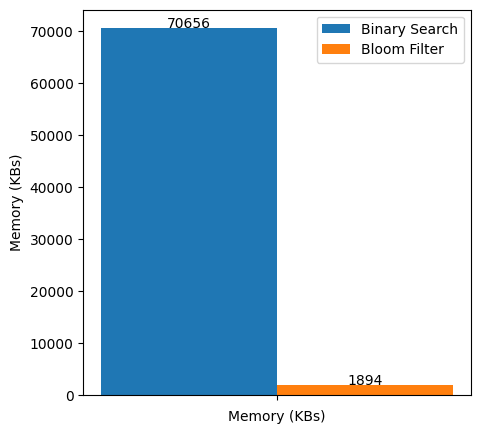

In [10]:
for hash_scheme in perf_df_1["HashScheme"].drop_duplicates().values:
    if hash_scheme != "kir-mitz":
        continue

    mem_perf_df = (
        time_acc_collision_perf_base_df.groupby(["FilterID", "HashAlgo", "HashScheme"])
        .mean(numeric_only=True)
        .reset_index()
    )


    mem_perf_df = mem_perf_df[mem_perf_df["HashScheme"] == hash_scheme]
    mem_perf_df = mem_perf_df[
        [
            "HashScheme", 
            "HashAlgo", 
            "BSMemory",
            "FilterSize"
        ]
    ]

    mem_perf_df["BSMemory"] = mem_perf_df["BSMemory"] / (8 * 1024)
    mem_perf_df["FilterSize"] = mem_perf_df["FilterSize"] / (8 * 1024)
    
    mem_perf_df["BSMemory"] = mem_perf_df["BSMemory"].astype(int)
    mem_perf_df["FilterSize"] = mem_perf_df["FilterSize"].astype(int)

bin_search_mem = mem_perf_df["BSMemory"].head(1)
bloom_filter_mem = mem_perf_df["FilterSize"].head(1)

# Set the positions of the bars on the x-axis
x = np.arange(1)
width = 0.15  # Reduced width

plt.figure(figsize=(5, 5))  # Slightly wider figure

# Create the first set of bars
plt.bar(
    x - width / 2, bin_search_mem, width, label="Binary Search"
)

# Create the second set of bars
plt.bar(
    x + width / 2, bloom_filter_mem, width, label="Bloom Filter"
)

# Adjust text placement dynamically
for i, v in enumerate(bin_search_mem):
    plt.text(i - width / 2, v + 0.1, str(v)[:6], ha="center")  # Adjusted ha

for i, v in enumerate(bloom_filter_mem):
    plt.text(i + width / 2, v + 0.1, str(v)[:6], ha="center")  # Adjusted ha

# Add labels, title, and legend
plt.xlabel("Memory (KBs)")
plt.ylabel("Memory (KBs)")
plt.xticks(x, [""])  # Hide x-axis labels
plt.legend()

# Save and show the chart
plot_filename = f"mem-{hash_scheme.replace('-', '_')}"
plt.savefig(f"./{plot_filename}.svg")
plt.show()


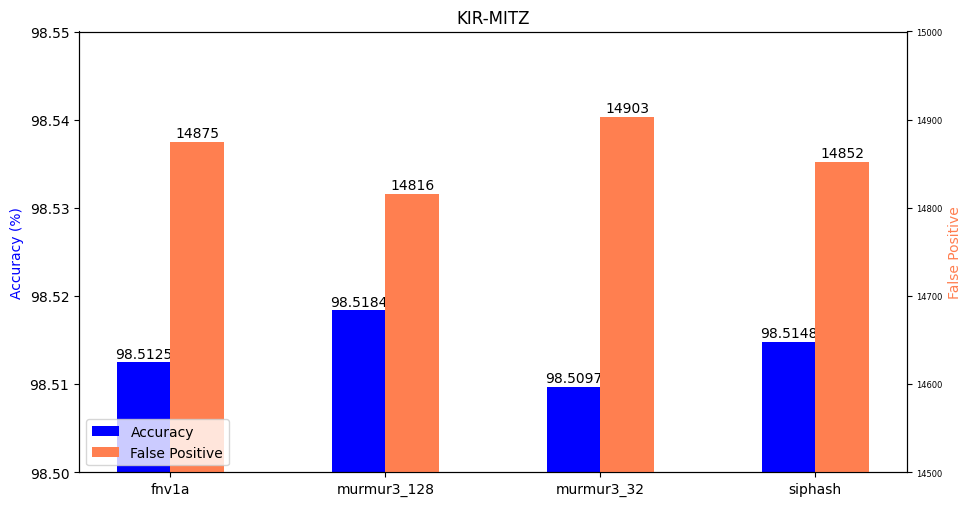

In [11]:
min_samples = 28000
for hash_scheme in perf_df_1["HashScheme"].drop_duplicates().values:
    acc_perf_df = (
        time_acc_collision_perf_base_df
        .groupby(["FilterID", "HashAlgo", "HashScheme"])
        .mean(numeric_only=True)
        .reset_index()
    )

    # Sample data
    acc_perf_df = acc_perf_df[acc_perf_df["HashScheme"] == hash_scheme]
    hash_algo = acc_perf_df["HashAlgo"]

    acc_perf_df['Accuracy'] = acc_perf_df['Accuracy'] * 100
    accuracy = acc_perf_df['Accuracy']

    false_positive = (acc_perf_df['F3'] + acc_perf_df['F4'] + acc_perf_df['F5'])
    false_positive = false_positive.astype(int).to_list()
    acc_perf_df.to_csv("test.csv")
    

    x = np.arange(len(hash_algo))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(10, 5))  # Adjust figure size for better readability

    # Plot the first set of bars (Sales)
    rects1 = ax1.bar(x - width/2, accuracy, width, label='Accuracy', color='blue')
    ax1.set_ylabel('Accuracy (%)', color='blue')
    ax1.tick_params(axis='y')

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot the second set of bars (Rating)
    rects2 = ax2.bar(x + width/2, false_positive, width, label='False Positive', color='coral')
    ax2.set_ylabel('False Positive', color='coral')
    ax2.tick_params(axis='y')

    # Set x-axis labels and title
    ax1.set_xticks(x)
    ax1.set_xticklabels(hash_algo)
    # plt.title('Double Bar Chart with Two Different Y-Axes')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles, labels = lines1 + lines2, labels1 + labels2
    # Legend in lower left, outside the plot area
    legend = ax2.legend(handles, labels, loc="lower left")
    ax1.set_ylim(bottom=0.9850 * 100, top=0.9855 * 100)
    ax2.set_ylim(bottom=14500,top=15000)

    # Add value labels on top of bars (optional)
    def autolabel(rects, ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height)[:7],
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax2)

    plt.xlabel("Hash variants")
    plt.tight_layout() #adjust layout to prevent labels from overlapping
    plt.title(hash_scheme.upper())
    
    plot_filename = f"acc-{hash_scheme.replace('-', '_')}"
    plt.tick_params(axis='both', which='major', labelsize=6)
    
    plt.savefig(f"./{plot_filename}.svg")
    plt.show()
    acc_perf_df.to_json(f"./{plot_filename}.json")

    # import tikzplotlib
    # tikzplotlib.save(f"tex/accuracy-{hash_scheme.replace("-", "_")}.tex")

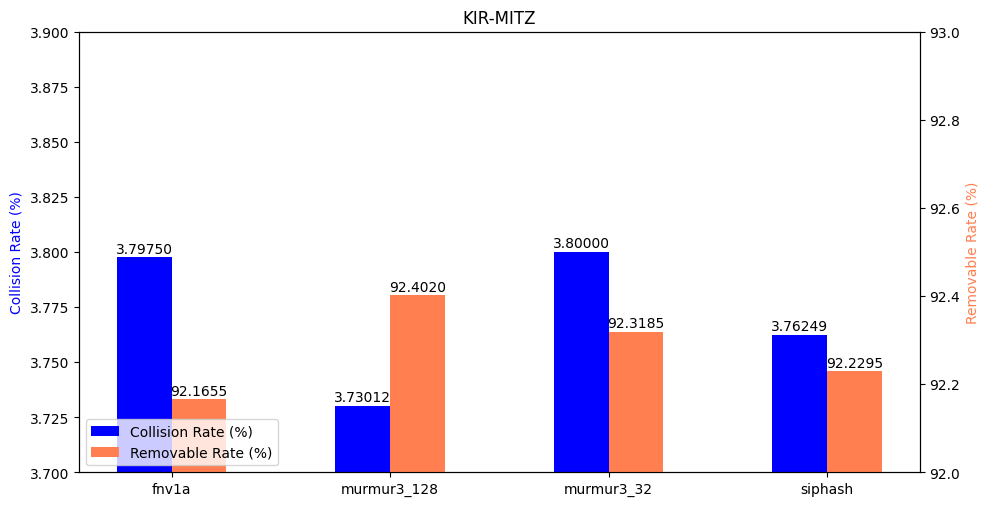

In [12]:
for hash_scheme in perf_df_1["HashScheme"].drop_duplicates().values:
    collision_perf_df = (
        time_acc_collision_perf_base_df
        .groupby(["FilterID", "HashAlgo", "HashScheme"])
        .mean(numeric_only=True)
        .reset_index()
    )
    removable_perf_df = (
        removable_perf_base_df
        .groupby(["FilterID", "HashAlgo", "HashScheme"])
        .mean(numeric_only=True)
        .reset_index()
    )
    

    # Sample data
    collision_perf_df: pd.DataFrame = collision_perf_df[collision_perf_df["HashScheme"] == hash_scheme]
    removable_perf_df: pd.DataFrame = removable_perf_df[removable_perf_df["HashScheme"] == hash_scheme]

    bigger_df = (
        collision_perf_df 
        if collision_perf_df.shape[0] >= removable_perf_df.shape[0]
        else removable_perf_df
    )

    hash_algo = bigger_df["HashAlgo"]
    algo_scheme = bigger_df[["HashAlgo", "HashScheme"]]
    collision_perf_df = pd.merge(
        bigger_df, 
        collision_perf_df, 
        how="left", 
        on=["HashAlgo", "HashScheme"],
        suffixes=("_big", "_col"),
    )
    removable_perf_df = pd.merge(
        bigger_df,
        removable_perf_df, 
        how="left", 
        on=["HashAlgo", "HashScheme"],
        suffixes=("_big", "_rem"),
    )
    

    collision_rate = collision_perf_df["NofCollision_col"] / collision_perf_df["NofOperand_col"]
    removable_rate = removable_perf_df["NofRemovable_rem"] / removable_perf_df["NofOperand_rem"]

    collision_rate = collision_rate * 100.0
    removable_rate = removable_rate * 100.0

    x = np.arange(len(hash_algo))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(10, 5))  # Adjust figure size for better readability

    # Plot the first set of bars (Sales)
    rects1 = ax1.bar(x - width/2, collision_rate, width, label='Collision Rate (%)', color='blue')
    ax1.set_ylabel('Collision Rate (%)', color='blue')
    ax1.tick_params(axis='y')

    # Create a second y-axis
    ax2 = ax1.twinx()
    

    # Plot the second set of bars (Rating)
    rects2 = ax2.bar(x + width/2, removable_rate, width, label='Removable Rate (%)', color='coral')
    ax2.set_ylabel('Removable Rate (%)', color='coral')
    ax2.tick_params(axis='y')

    # Set x-axis labels and title
    ax1.set_xticks(x)
    ax1.set_xticklabels(hash_algo)
    # plt.title('Double Bar Chart with Two Different Y-Axes')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles, labels = lines1 + lines2, labels1 + labels2
    # Legend in lower left, outside the plot area
    legend = ax2.legend(handles, labels, loc="lower left")
    
    ax1.set_ylim(bottom=0.037 * 100, top=0.039 * 100)
    ax2.set_ylim(bottom=0.920 * 100, top=0.930 * 100)

    # Add value labels on top of bars (optional)
    def autolabel(rects, ax):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height).ljust(7, "0")[:7],
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1, ax1)
    autolabel(rects2, ax2)

    plt.tight_layout() #adjust layout to prevent labels from overlapping
    plt.title(hash_scheme.upper())
    
    plot_filename = f"rate-{hash_scheme.replace('-', '_')}"
    
    plt.savefig(f"./{plot_filename}.svg")
    plt.show()
    removable_perf_df.to_json(f"./rem-{plot_filename}.json")
    collision_perf_df.to_json(f"./col-{plot_filename}.json")

    # import tikzplotlib
    # tikzplotlib.save(f"tex/accuracy-{hash_scheme.replace("-", "_")}.tex")